## Data 

#### Data for the observations of 1000 forests consisting on:

+ leaf area index [lai]: a measure of forest structure that indicates how dense a forest is. The higher the value, the denser the forest. Values below 1 correspond to Woodlands, values above 1 describe actual forests, than can be divided into different classes (‘open forest’ ‘moderate dense forest’, ‘dense forest’ and ‘very dense forest’ with ascending leaf density. Typical values in Germany are around 3-6.
+ wetness: indicates how moist the soil is (values between 0% and 100%)
+ treeSpecies: describes the species of trees in the forest. Forests consist of pines or beech trees and mostly a mix of both
+ Sentinel_2A_{ABCD} columns with ABCD corresponding to a wavelength: reflection values corresponding to the bands of the actual satellite measurements
+ w{ABCD} columns with ABCD corresponding to a wavelength: contain the simulated sunlight reflection values for each wavelenth of the curve.

#### Import all the necessary libraries

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score,r2_score
from sklearn import svm
from sklearn.ensemble import VotingRegressor,RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import time
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

# Display all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### Dataset

In [5]:
df = pd.read_csv('../Ayush/RtmSimulation_kickstart.csv', index_col= 0)

In [6]:
df.head()

lai  wetness          treeSpecies  Sentinel_2A_492.4  Sentinel_2A_559.8  \
id                                                                             
1   5.10     0.36   predominantly_pine           0.062092           0.131702   
2   5.34     0.47  predominantly_beech           0.052807           0.129987   
3   4.53     0.68   predominantly_pine           0.047937           0.139421   
4   2.10     0.80  predominantly_beech           0.045907           0.107761   
5   5.34     0.48                mixed           0.051712           0.136293   

    Sentinel_2A_664.6  Sentinel_2A_704.1  Sentinel_2A_740.5  \
id                                                            
1            0.043197           0.177134           0.401750   
2            0.043061           0.153641           0.407523   
3            0.045780           0.157121           0.395428   
4            0.033984           0.128237           0.341315   
5            0.041502           0.167564           0.407460   

    Sentinel_2A_782.8  Sentinel_2A_832.8  Sentinel_2A_864.7  \
id                                                            
1            0.458003           0.463287           0.465697   
2            0.466853           0.477236           0.469157   
3            0.441620           0.448626           0.448503   
4            0.385277           0.382241           0.380013   
5            0.454137           0.464966           0.459594   

    Sentinel_2A_1613.7  Sentinel_2A_2202.4      w400      w401      w402  \
id                                                                         
1             0.224946            0.094398  0.022230  0.030883  0.029970   
2             0.228034            0.096956  0.024134  0.015525  0.022257   
3             0.215900            0.090629  0.024915  0.027422  0.018752   
4             0.241785            0.105857  0.034277  0.017736  0.015652   
5             0.220666            0.085389  0.024460  0.016685  0.023231   

        w403      w404      w405      w406      w407      w408      w409  \
id                                                                         
1   0.015742  0.028419  0.023822  0.014995  0.028002  0.020052  0.014496   
2   0.026891  0.018370  0.021810  0.026465  0.023270  0.019074  0.021094   
3   0.024364  0.024786  0.035412  0.024318  0.021585  0.009862  0.023946   
4   0.034065  0.026549  0.024521  0.019540  0.028953  0.013022  0.016307   
5   0.022971  0.028674  0.025160  0.031652  0.013545  0.021179  0.017351   

        w410      w411      w412      w413      w414      w415      w416  \
id                                                                         
1   0.031057  0.022139  0.023681  0.023649  0.020518  0.025360  0.017879   
2   0.030539  0.028203  0.038363  0.014252  0.030028  0.016924  0.023882   
3   0.029931  0.024564  0.030854  0.015016  0.026155  0.027183  0.026259   
4   0.025869  0.018659  0.019903  0.029457  0.031928  0.017208  0.028434   
5   0.022714  0.024175  0.025461  0.024557  0.024825  0.018796  0.026511   

        w417      w418      w419      w420      w421      w422      w423  \
id                                                                         
1   0.023101  0.013483  0.032709  0.014524  0.019922  0.020168  0.031608   
2   0.020182  0.026620  0.026812  0.023941  0.019716  0.016922  0.022492   
3   0.022504  0.023487  0.015305  0.027493  0.026381  0.039102  0.023598   
4   0.020619  0.023059  0.026708  0.021960  0.025332  0.031939  0.020589   
5   0.026499  0.022395  0.026752  0.022025  0.022830  0.025016  0.022642   

        w424      w425      w426      w427      w428      w429      w430  \
id                                                                         
1   0.026906  0.025231  0.020051  0.029161  0.030438  0.025054  0.025670   
2   0.019899  0.030764  0.021958  0.027767  0.016015  0.019535  0.027772   
3   0.033522  0.024928  0.018391  0.018606  0.029177  0.031410  0.027411   
4   0.019737  0.021988  0.022078  0.030973  0.01

#### Description and Stats

In [7]:
len(df)

1000

In [8]:
columns_with_nan = df.columns[df.isnull().any()].tolist()
columns_with_nan

['Sentinel_2A_704.1',
 'Sentinel_2A_740.5',
 'Sentinel_2A_782.8',
 'w469',
 'w470',
 'w471',
 'w473',
 'w474']

In [9]:
na_values = df.isna().sum()

In [10]:
na_values[:10]

lai                   0
wetness               0
treeSpecies           0
Sentinel_2A_492.4     0
Sentinel_2A_559.8     0
Sentinel_2A_664.6     0
Sentinel_2A_704.1    10
Sentinel_2A_740.5    10
Sentinel_2A_782.8    10
Sentinel_2A_832.8     0
dtype: int64

+ Only 8 columns have 10 missing values each, which is comparatively low considering our overall dataset of 1000 data points.


In [11]:
df.columns

Index(['lai', 'wetness', 'treeSpecies', 'Sentinel_2A_492.4',
       'Sentinel_2A_559.8', 'Sentinel_2A_664.6', 'Sentinel_2A_704.1',
       'Sentinel_2A_740.5', 'Sentinel_2A_782.8', 'Sentinel_2A_832.8',
       ...
       'w2491', 'w2492', 'w2493', 'w2494', 'w2495', 'w2496', 'w2497', 'w2498',
       'w2499', 'w2500'],
      dtype='object', length=2114)

In [12]:
Sentinel_2A_values = df.columns[4:13]
Sentinel_2A_values

Index(['Sentinel_2A_559.8', 'Sentinel_2A_664.6', 'Sentinel_2A_704.1',
       'Sentinel_2A_740.5', 'Sentinel_2A_782.8', 'Sentinel_2A_832.8',
       'Sentinel_2A_864.7', 'Sentinel_2A_1613.7', 'Sentinel_2A_2202.4'],
      dtype='object')

In [13]:
wavelengths = df.columns[13:]
wavelengths

Index(['w400', 'w401', 'w402', 'w403', 'w404', 'w405', 'w406', 'w407', 'w408',
       'w409',
       ...
       'w2491', 'w2492', 'w2493', 'w2494', 'w2495', 'w2496', 'w2497', 'w2498',
       'w2499', 'w2500'],
      dtype='object', length=2101)

In [14]:
df.describe()

lai      wetness  Sentinel_2A_492.4  Sentinel_2A_559.8  \
count  1000.000000  1000.000000        1000.000000        1000.000000   
mean      4.110860     0.595180           0.060456           0.128869   
std       1.934073     0.202594           0.051734           0.033463   
min       0.000000     0.000000           0.006332           0.001431   
25%       2.747500     0.460000           0.047974           0.120970   
50%       4.150000     0.590000           0.053045           0.128655   
75%       5.400000     0.732500           0.057838           0.135437   
max      11.040000     1.000000           0.505262           0.491022   

       Sentinel_2A_664.6  Sentinel_2A_704.1  Sentinel_2A_740.5  \
count        1000.000000         990.000000         990.000000   
mean            0.048915           0.162026           0.372335   
std             0.046418           0.043214           0.058903   
min             0.012693           0.003643           0.006588   
25%             0.037029           0.151239           0.369331   
50%             0.041572           0.160083           0.390651   
75%             0.046538           0.167251           0.399888   
max             0.508572           0.494311           0.495489   

       Sentinel_2A_782.8  Sentinel_2A_832.8  Sentinel_2A_864.7  \
count         990.000000        1000.000000        1000.000000   
mean            0.427862           0.430069           0.433616   
std             0.072191           0.071232           0.064241   
min            -0.003877          -0.005051          -0.017379   
25%             0.421068           0.423169           0.425262   
50%             0.448781           0.450510           0.451373   
75%             0.463771           0.464729           0.465548   
max             0.528556           0.533968           0.528233   

       Sentinel_2A_1613.7  Sentinel_2A_2202.4         w400         w401  \
count         1000.000000         1000.000000  1000.000000  1000.000000   
mean             0.232389            0.104000     0.026803     0.026697   
std              0.038429            0.036449     0.018751     0.018592   
min              0.005132            0.074606     0.008098     0.007424   
25%              0.219497            0.089434     0.019608     0.019648   
50%              0.227017            0.095820     0.023661     0.023469   
75%              0.238625            0.104508     0.028136     0.027519   
max              0.487680            0.439335     0.213610     0.201294   

              w402         w403         w404         w405         w406  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.026755     0.026595     0.027035     0.027057     0.026776   
std       0.018615     0.018265     0.018863     0.018667     0.018245   
min       0.007265     0.005925     0.007925     0.007112     0.002622   
25%       0.019782     0.019255     0.019945     0.019692     0.019798   
50%       0.023489     0.023703     0.024026     0.023874     0.023789   
75%       0.027563     0.028117     0.028070     0.028297     0.028008   
max       0.207869     0.199513     0.208192     0.212092     0.205981   

              w407         w408         w409         w410         w411  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.027286     0.026749     0.027269     0.026895     0.027203   
std       0.019458     0.018284     0.018140     0.018344     0.018994   
min       0.000000     0.006269     0.002282     0.005589     0.006447   
25%       0.020308     0.019778     0.020449     0.019942     0.020208   
50%       0.024364     0.023594     0.024218     0.023987     0.023901   
75%       0.028193     0.028121     0.028464     0.028146     0.028258   
max       0.241260     0.197095     0.194847     0.204434     0.199120   

              w412         w413         w414         w415         w416  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Columns: 2114 entries, lai to w2500
dtypes: float64(2113), object(1)
memory usage: 16.1+ MB


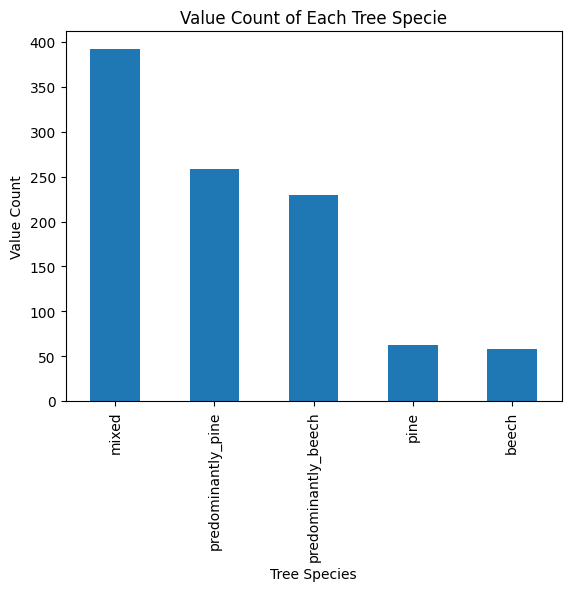

In [16]:
# Tree species value count
df['treeSpecies'].value_counts().plot(kind='bar');
plt.xlabel('Tree Species')
plt.ylabel('Value Count')
plt.title('Value Count of Each Tree Specie')
plt.show()

#### Value Distribution

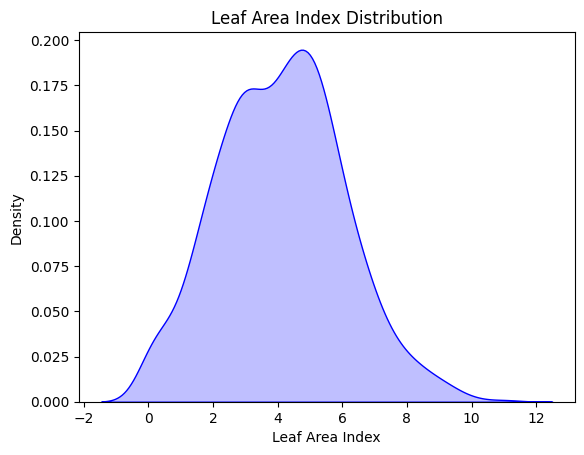

In [17]:
# Assuming 'leaf area index' is a column in your DataFrame
sns.kdeplot(df['lai'], fill=True, color='blue', label='Density Plot')

# Add labels and title
plt.xlabel('Leaf Area Index')
plt.ylabel('Density')
plt.title('Leaf Area Index Distribution')

# Show the plot
plt.show()


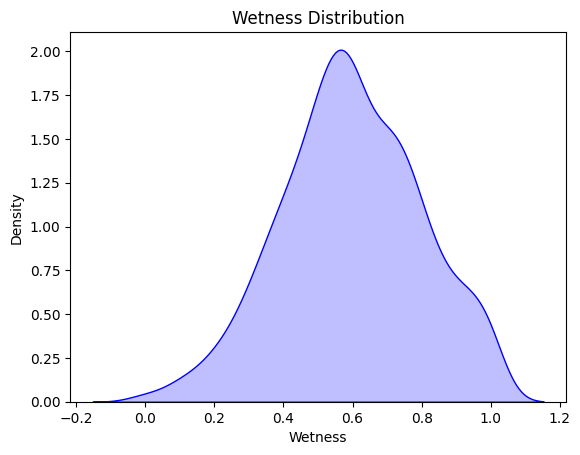

In [18]:
# Assuming 'leaf area index' is a column in your DataFrame
sns.kdeplot(df['wetness'], fill=True, color='blue', label='Density Plot')

# Add labels and title
plt.xlabel('Wetness')
plt.ylabel('Density')
plt.title('Wetness Distribution')

# Show the plot
plt.show()

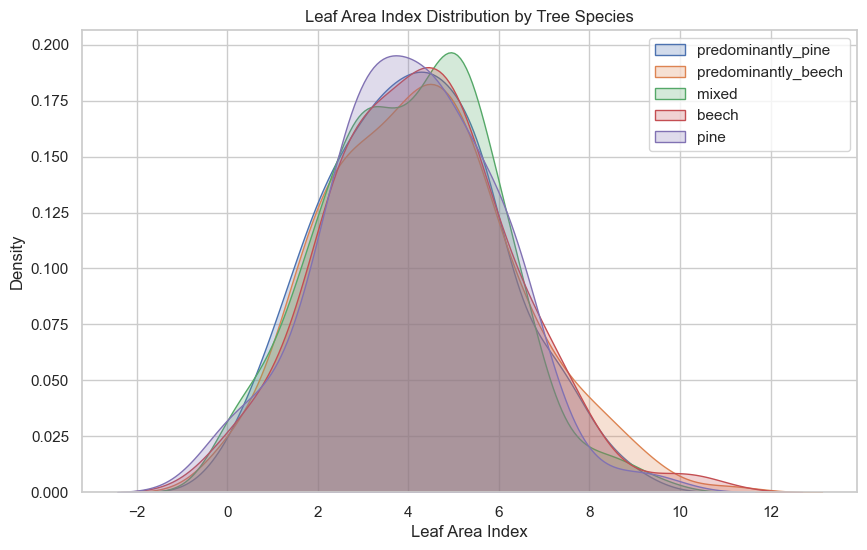

In [19]:
# Assuming 'leaf area index' and 'treeSpecies' are columns in your DataFrame
sns.set(style="whitegrid")

# Create a separate density plot for each tree species
plt.figure(figsize=(10, 6))
for species in df['treeSpecies'].unique():
    sns.kdeplot(df[df['treeSpecies'] == species]['lai'], label=species, shade=True)

# Add labels and title
plt.xlabel('Leaf Area Index')
plt.ylabel('Density')
plt.title('Leaf Area Index Distribution by Tree Species')

# Show legend
plt.legend()

# Show the plot
plt.show()


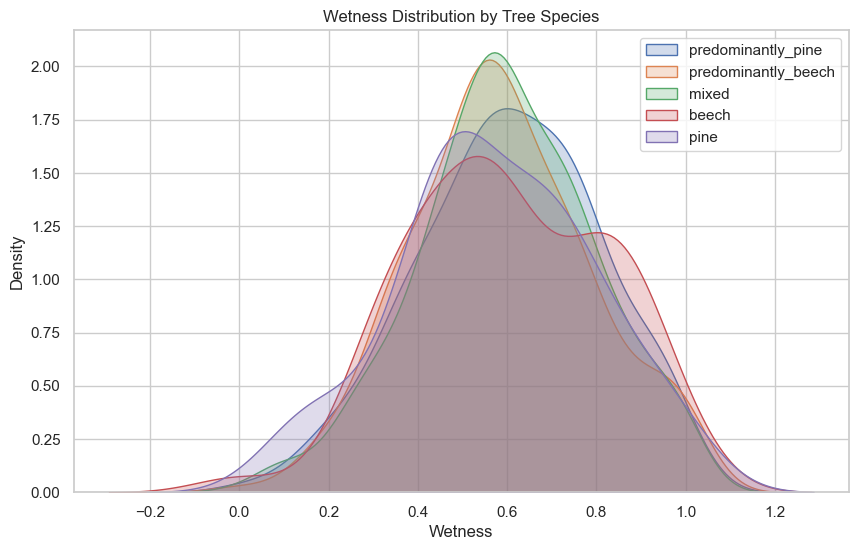

In [20]:
# Assuming 'leaf area index' and 'treeSpecies' are columns in your DataFrame
sns.set(style="whitegrid")

# Create a separate density plot for each tree species
plt.figure(figsize=(10, 6))
for species in df['treeSpecies'].unique():
    sns.kdeplot(df[df['treeSpecies'] == species]['wetness'], label=species, shade=True)

# Add labels and title
plt.xlabel('Wetness')
plt.ylabel('Density')
plt.title('Wetness Distribution by Tree Species')

# Show legend
plt.legend()

# Show the plot
plt.show()

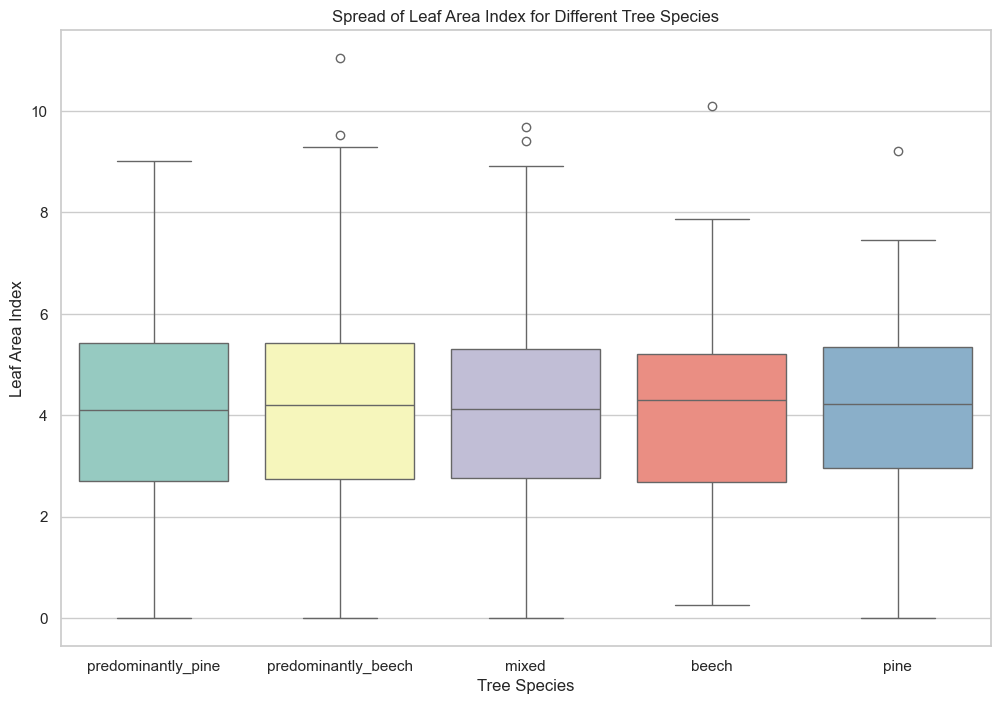

In [21]:
# Create a box plot for the spread of 'leaf area index' for different tree species
plt.figure(figsize=(12, 8))
sns.boxplot(x='treeSpecies', y='lai', data=df, palette='Set3')

# Add labels and title
plt.xlabel('Tree Species')
plt.ylabel('Leaf Area Index')
plt.title('Spread of Leaf Area Index for Different Tree Species')

# Show the plot
plt.show()


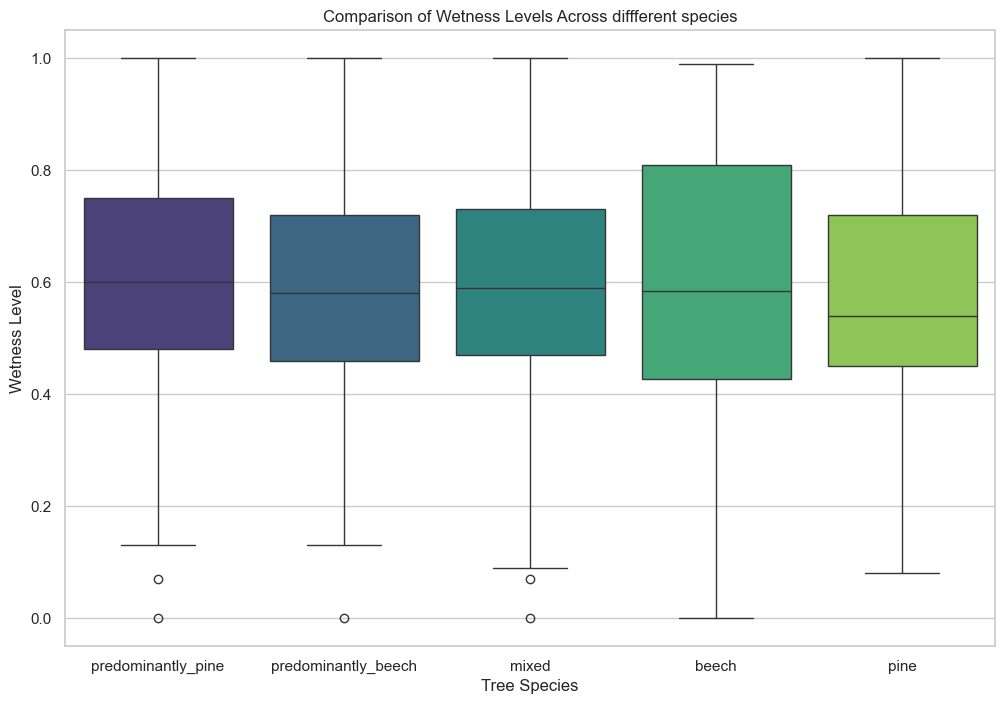

In [22]:
# Create a box plot for wetness levels across different tree species
plt.figure(figsize=(12, 8))
sns.boxplot(x='treeSpecies', y='wetness', data=df, palette='viridis')

# Add labels and title
plt.xlabel('Tree Species')
plt.ylabel('Wetness Level')
plt.title('Comparison of Wetness Levels Across diffferent species')

# Show the plot
plt.show()


### Model Training

#### Provided RF Base_Model

#### Use only `wetness` and `Sentinel_2A_....` columns

In [23]:
base_df = df.drop('treeSpecies', axis = 1)

In [24]:
base_df.columns[1:12]

Index(['wetness', 'Sentinel_2A_492.4', 'Sentinel_2A_559.8',
       'Sentinel_2A_664.6', 'Sentinel_2A_704.1', 'Sentinel_2A_740.5',
       'Sentinel_2A_782.8', 'Sentinel_2A_832.8', 'Sentinel_2A_864.7',
       'Sentinel_2A_1613.7', 'Sentinel_2A_2202.4'],
      dtype='object')

In [25]:
y = base_df['lai']

In [26]:
X = base_df.iloc[:,1:12]

In [27]:
X.columns

Index(['wetness', 'Sentinel_2A_492.4', 'Sentinel_2A_559.8',
       'Sentinel_2A_664.6', 'Sentinel_2A_704.1', 'Sentinel_2A_740.5',
       'Sentinel_2A_782.8', 'Sentinel_2A_832.8', 'Sentinel_2A_864.7',
       'Sentinel_2A_1613.7', 'Sentinel_2A_2202.4'],
      dtype='object')

#### Simple regression models, no hyperparameter optimization

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

##### Random Forest Regressor

In [29]:
rf = RandomForestRegressor(random_state=42)

In [30]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
rf.score(X_train, y_train)

0.8535686483355318

In [32]:
rf.score(X_test, y_test)

0.7739801970074438

#### Analysis of provided RF model
+ I wanted to get insights from the already provided work so that I can come up with my own approach.

In [33]:
train_predictions = rf.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

In [34]:
train_mse

0.5252586223393081

In [35]:
# Predictions on the test set
test_predictions = rf.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)

In [36]:
test_mse

0.9794874984564985

*Comments*

**Training MSE (0.52):**

A lower training MSE is generally desirable, indicating a better fit to the training data. However, excessively low training MSE might suggest overfitting, where the model is capturing noise in the training data.

**Test MSE (0.97):**

A higher test MSE compared to the training MSE suggests that the model may not be generalizing well to new data. Since the test MSE is much higher than the training MSE, it indicates overfitting, where the model has learned patterns specific to the training set that do not apply to other data.

In [37]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean CV MSE: {np.mean(-cv_scores):.4f}")


Cross-Validation MSE Scores: [0.69774532 0.90394144 0.5996884  1.00703489 0.56383226]
Mean CV MSE: 0.7544


*Comments*

+ If the mean cross-validation MSE is close to the training MSE (0.52), it suggests that the model is consistent in performance across different subsets of the data.
+ If the mean cross-validation MSE is significantly lower than the test MSE (0.97), it may indicate that the model is overfitting to the training data.


### SVM Voting  Regressor
**Approach:**
Use individual regressors for each tree specie since they have different features/ the reflected lights will be different and therefore, the measured Sentinel values as well as the wetness should be different. Then use a voting algorithm to predict the leaf area index.

+ **Feature_selection:** Since the w400 till w2500 columns have been simulated from the Sentinel columns and I do not know how they were simulated and how off these values are, I will only be using the measured values. This approach is not ideal as I am not taking advantage of all the available data or exploring the simulated values. 
One can use feature selection approaches such as `Recursive_Feature_Elimination` to find the relevant features from these ranges.

In [38]:
# Encode the Tree Species
encoder = OneHotEncoder(sparse_output=True, drop='first')  
X_encoded = pd.get_dummies(df[['treeSpecies']])

In [39]:
X_encoded.head()

,treeSpecies_beech,treeSpecies_mixed,treeSpecies_pine,treeSpecies_predominantly_beech,treeSpecies_predominantly_pine
id,,,,,
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,False,False,True
4,False,False,False,True,False
5,False,True,False,False,False


In [40]:
len(X_encoded)

1000

In [41]:
# Concatenate the encoded features with other features 
X_encoded = pd.concat([df.drop(['treeSpecies'], axis=1), X_encoded], axis=1)

In [42]:
X_encoded.head()

lai  wetness  Sentinel_2A_492.4  Sentinel_2A_559.8  Sentinel_2A_664.6  \
id                                                                           
1   5.10     0.36           0.062092           0.131702           0.043197   
2   5.34     0.47           0.052807           0.129987           0.043061   
3   4.53     0.68           0.047937           0.139421           0.045780   
4   2.10     0.80           0.045907           0.107761           0.033984   
5   5.34     0.48           0.051712           0.136293           0.041502   

    Sentinel_2A_704.1  Sentinel_2A_740.5  Sentinel_2A_782.8  \
id                                                            
1            0.177134           0.401750           0.458003   
2            0.153641           0.407523           0.466853   
3            0.157121           0.395428           0.441620   
4            0.128237           0.341315           0.385277   
5            0.167564           0.407460           0.454137   

    Sentinel_2A_832.8  Sentinel_2A_864.7  Sentinel_2A_1613.7  \
id                                                             
1            0.463287           0.465697            0.224946   
2            0.477236           0.469157            0.228034   
3            0.448626           0.448503            0.215900   
4            0.382241           0.380013            0.241785   
5            0.464966           0.459594            0.220666   

    Sentinel_2A_2202.4      w400      w401      w402      w403      w404  \
id                                                                         
1             0.094398  0.022230  0.030883  0.029970  0.015742  0.028419   
2             0.096956  0.024134  0.015525  0.022257  0.026891  0.018370   
3             0.090629  0.024915  0.027422  0.018752  0.024364  0.024786   
4             0.105857  0.034277  0.017736  0.015652  0.034065  0.026549   
5             0.085389  0.024460  0.016685  0.023231  0.022971  0.028674   

        w405      w406      w407      w408      w409      w410      w411  \
id                                                                         
1   0.023822  0.014995  0.028002  0.020052  0.014496  0.031057  0.022139   
2   0.021810  0.026465  0.023270  0.019074  0.021094  0.030539  0.028203   
3   0.035412  0.024318  0.021585  0.009862  0.023946  0.029931  0.024564   
4   0.024521  0.019540  0.028953  0.013022  0.016307  0.025869  0.018659   
5   0.025160  0.031652  0.013545  0.021179  0.017351  0.022714  0.024175   

        w412      w413      w414      w415      w416      w417      w418  \
id                                                                         
1   0.023681  0.023649  0.020518  0.025360  0.017879  0.023101  0.013483   
2   0.038363  0.014252  0.030028  0.016924  0.023882  0.020182  0.026620   
3   0.030854  0.015016  0.026155  0.027183  0.026259  0.022504  0.023487   
4   0.019903  0.029457  0.031928  0.017208  0.028434  0.020619  0.023059   
5   0.025461  0.024557  0.024825  0.018796  0.026511  0.026499  0.022395   

        w419      w420      w421      w422      w423      w424      w425  \
id                                                                         
1   0.032709  0.014524  0.019922  0.020168  0.031608  0.026906  0.025231   
2   0.026812  0.023941  0.019716  0.016922  0.022492  0.019899  0.030764   
3   0.015305  0.027493  0.026381  0.039102  0.023598  0.033522  0.024928   
4   0.026708  0.021960  0.025332  0.031939  0.020589  0.019737  0.021988   
5   0.026752  0.022025  0.022830  0.025016  0.022642  0.032792  0.022930   

        w426      w427      w428      w429      w430      w431      w432  \
id                                                                         
1   0.020051  0.029161  0.030438  0.025054  0.025670  0.029106  0.035617   
2   0.021958  0.027767  0.016015  0.019535  0.027772  0.022595  0.024979   
3   0.018391  0.018606  0.029177  0.031410  0.027411  0.023684  0.020582   
4   0.022078  0.030973  0.015835  0.016317  0.029141  0

In [43]:
train_columns = ['lai','wetness', 'Sentinel_2A_492.4', 'Sentinel_2A_559.8',
       'Sentinel_2A_664.6', 'Sentinel_2A_704.1', 'Sentinel_2A_740.5',
       'Sentinel_2A_782.8', 'Sentinel_2A_832.8', 'Sentinel_2A_864.7',
       'Sentinel_2A_1613.7', 'Sentinel_2A_2202.4', 'treeSpecies_mixed',
       'treeSpecies_pine','treeSpecies_predominantly_beech','treeSpecies_predominantly_pine','treeSpecies_beech']

In [44]:
# only keep the training columns 
X_encoded = X_encoded[train_columns].copy()

In [45]:
X_encoded.head()

,lai,wetness,Sentinel_2A_492.4,Sentinel_2A_559.8,Sentinel_2A_664.6,Sentinel_2A_704.1,Sentinel_2A_740.5,Sentinel_2A_782.8,Sentinel_2A_832.8,Sentinel_2A_864.7,Sentinel_2A_1613.7,Sentinel_2A_2202.4,treeSpecies_mixed,treeSpecies_pine,treeSpecies_predominantly_beech,treeSpecies_predominantly_pine,treeSpecies_beech
id,,,,,,,,,,,,,,,,,
1,5.10,0.36,0.062092,0.131702,0.043197,0.177134,0.401750,0.458003,0.463287,0.465697,0.224946,0.094398,False,False,False,True,False
2,5.34,0.47,0.052807,0.129987,0.043061,0.153641,0.407523,0.466853,0.477236,0.469157,0.228034,0.096956,False,False,True,False,False
3,4.53,0.68,0.047937,0.139421,0.045780,0.157121,0.395428,0.441620,0.448626,0.448503,0.215900,0.090629,False,False,False,True,False
4,2.10,0.80,0.045907,0.107761,0.033984,0.128237,0.341315,0.385277,0.382241,0.380013,0.241785,0.105857,False,False,True,False,False
5,5.34,0.48,0.051712,0.136293,0.041502,0.167564,0.407460,0.454137,0.464966,0.459594,0.220666,0.085389,True,False,False,False,False


In [46]:
# Create model for each tree species
models = {}
categories = df['treeSpecies'].unique()

for category in categories:
    keep_category = "treeSpecies_" + str(category)
    subset_data = X_encoded[X_encoded[keep_category] == 1]
    subset_data.dropna(inplace=True)
    X_subset = subset_data.drop(['lai'], axis=1) 
    y_subset = subset_data['lai']
    
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset,test_size=0.2, random_state=42)

    # Train SVM model for the current category
    svm_model = svm.SVR(kernel='rbf')  
    svm_model.fit(X_train, y_train)

    models[category] = svm_model

In [47]:
# Train the voting regressor on the previously trained models
voting_regressorr = VotingRegressor(estimators=[(str(category), model) for category, model in models.items()])
X_encoded.dropna(inplace=True)

X = X_encoded.drop(['lai'], axis=1) 
y = X_encoded["lai"]

In [48]:
# Fit the voting regressor on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
voting_regressorr.fit(X_train,y_train)
end_time = time.time()
train_time = end_time - start_time
print(f"Training_time: {train_time}")

start_time = time.time()
final_predictions = voting_regressorr.predict(X_test)
end_time = time.time()
pred_time = end_time - start_time

print(f"Prediction_time: {pred_time}")

Training_time: 0.06632804870605469
Prediction_time: 0.028888940811157227


In [49]:
train_predictions = voting_regressorr.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f"train_mse: {train_mse},train_mae: {train_mae}, train_r2: {train_r2}")

train_mse: 1.6277184701115313,train_mae: 0.9541747654872763, train_r2: 0.5693999878120666


In [50]:
test_mse = mean_squared_error(y_test, final_predictions)
test_mae = mean_absolute_error(y_test, final_predictions)
test_r2 = r2_score(y_test, final_predictions)
print(f"test_mse: {test_mse},test_mae: {test_mae}, test_r2: {test_r2}")

test_mse: 1.8382456687536322,test_mae: 1.035306782798182, test_r2: 0.5114597242258718


In [51]:
cv_scores = cross_val_score(voting_regressorr, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean CV MSE: {np.mean(-cv_scores):.4f}")

Cross-Validation MSE Scores: [1.63977236 2.19323639 1.4185157  2.11270418 1.62223453]
Mean CV MSE: 1.7973


In [52]:
cv_scores = cross_val_score(voting_regressorr, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-Validation MAE Scores: {-cv_scores}")
print(f"Mean CV MAE: {np.mean(-cv_scores):.4f}")

Cross-Validation MAE Scores: [0.98317591 1.12348034 0.94318816 1.0649871  0.9587669 ]
Mean CV MAE: 1.0147


+ The model seems to be performing consistently across training, test, and cross-validation datasets.
+ The MSE and MAE values are within a reasonable range, indicating that the model is making accurate predictions.
+ The cross-validation results provide an additional layer of confidence in the model's generalization performance.

### RF Voter Regressor

In [53]:
models = {}
categories = df['treeSpecies'].unique()

for category in categories:
    keep_category = "treeSpecies_" + str(category)
    subset_data = X_encoded[X_encoded[keep_category] == 1]
    subset_data.dropna(inplace=True)
    X_subset = subset_data.drop(['lai'], axis=1) 
    y_subset = subset_data['lai']
    
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

    # Train SVM model for the current category
    rf = RandomForestRegressor()  
    rf.fit(X_train, y_train)

    models[category] = rf

In [54]:
voting_regressorr = VotingRegressor(estimators=[(str(category), model) for category, model in models.items()])
X_encoded.dropna(inplace=True)

X = X_encoded.drop(['lai'], axis=1) 
y = X_encoded["lai"]

# Fit the voting regressor on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()
voting_regressorr.fit(X_train,y_train)
end_time = time.time()
train_time = end_time - start_time
print(f"Training_time: {train_time}")

# Get predictions from the voting regressor
final_predictions = voting_regressorr.predict(X_test)

Training_time: 1.6374468803405762


In [55]:
start_time = time.time()
train_predictions = voting_regressorr.predict(X_train)
end_time = time.time()
pred_time = end_time - start_time

print(f"Prediction_time: {pred_time}")

train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f"train_mse: {train_mse},train_mae: {train_mae}, train_r2: {train_r2}")

Prediction_time: 0.04305410385131836
train_mse: 0.07294272730154641,train_mae: 0.1693552835051546, train_r2: 0.9807035799852324


In [56]:
test_mse = mean_squared_error(y_test, final_predictions)
test_mae = mean_absolute_error(y_test, final_predictions)
test_r2 = r2_score(y_test, final_predictions)
print(f"test_mse: {test_mse},test_mae: {test_mae}, test_r2: {test_r2}")

test_mse: 0.5375136894948452,test_mae: 0.46767865979381434, test_r2: 0.857147991391038


In [57]:
cv_scores = cross_val_score(voting_regressorr, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean CV MSE: {np.mean(-cv_scores):.4f}")

Cross-Validation MSE Scores: [0.51388105 0.60402524 0.46897758 0.69391973 0.44422254]
Mean CV MSE: 0.5450


In [58]:
cv_scores = cross_val_score(voting_regressorr, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-Validation MAE Scores: {-cv_scores}")
print(f"Mean CV MAE: {np.mean(-cv_scores):.4f}")

Cross-Validation MAE Scores: [0.47668907 0.46651186 0.45715691 0.51943186 0.40376433]
Mean CV MAE: 0.4647


In [59]:
cv_scores = cross_val_score(voting_regressorr, X, y, cv=5, scoring='r2')

print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2: {np.mean(cv_scores):.4f}")

Cross-Validation R2 Scores: [0.85231728 0.86856421 0.86088187 0.82725417 0.86572258]
Mean CV R2: 0.8549


+ The model seems to be performing consistently across training, test, and cross-validation datasets.
+ The MSE and MAE values are within a reasonable range, indicating that the model is making accurate predictions.
+ The cross-validation results provide an additional layer of confidence in the model's generalization performance.

### Hyperparameter Tuning
Since the RF Model provides better results, I will Autotune on this regressor.

In [60]:
param_grid = {
    'predominantly_pine__n_estimators': [50, 100, 150],
    'predominantly_pine__max_depth': [None, 10, 20,100],
    'predominantly_beech__n_estimators': [50, 100, 150],
    'predominantly_beech__max_depth': [None, 10, 20,100],
    'mixed__n_estimators': [50, 100, 150],
    'mixed__max_depth': [None, 10, 20,100],
    'beech__n_estimators': [50,100,150],
    'beech__max_depth': [None, 10, 20,100],
    'pine__n_estimators': [50,150],
    'pine__max_depth': [None, 10, 20,100]
}

In [61]:
random_search = RandomizedSearchCV(estimator=voting_regressorr, param_distributions=param_grid, scoring='r2', cv=5,n_iter=100, n_jobs=-1)

In [62]:
# Fit the grid search to the data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=VotingRegressor(estimators=[('predominantly_pine',
                                                          RandomForestRegressor()),
                                                         ('predominantly_beech',
                                                          RandomForestRegressor()),
                                                         ('mixed',
                                                          RandomForestRegressor()),
                                                         ('beech',
                                                          RandomForestRegressor()),
                                                         ('pine',
                                                          RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'beech__max_depth': [None, 10, 20, 100],
                                        'beech__n_es...50],
                                        'mixed__max_depth': [None, 10, 20, 100],
                                        'mixed__n_estimators': [50, 100, 150],
                                        'pine__max_depth': [None, 10, 20, 100],
                                        'pine__n_estimators': [50, 150],
                                        'predominantly_beech__max_depth': [None,
                                                                           10,
                                                                           20,
                                                                           100],
                                        'predominantly_beech__n_estimators': [50,
                                                                              100,
                                                                              150],
                                        'predominantly_pine__max_depth': [None,
                                                                          10,
                                                                          20,
                                                                          100],
                                        'predominantly_pine__n_estimators': [50,
                                                                             100,
                                                                             150]},
                   scoring='r2')

In [63]:
# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'predominantly_pine__n_estimators': 50, 'predominantly_pine__max_depth': 20, 'predominantly_beech__n_estimators': 50, 'predominantly_beech__max_depth': 100, 'pine__n_estimators': 50, 'pine__max_depth': 10, 'mixed__n_estimators': 150, 'mixed__max_depth': None, 'beech__n_estimators': 50, 'beech__max_depth': None}


In [64]:
# Get the best model from the grid search
best_model = random_search.best_estimator_

In [65]:
# Evaluate the best model on the test set

start_time = time.time()
y_pred = best_model.predict(X_test)
end_time = time.time()
print(f"Prediction_time: {end_time - start_time}")

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test,y_pred)
test_mae = mean_absolute_error(y_test,y_pred)
print("Test R2 with Best Model:", test_r2)
print("Test MSE with Best Model:", test_mse)
print("Test MAE with Best Model:", test_mae)

Prediction_time: 0.017112016677856445
Test R2 with Best Model: 0.8568298726182799
Test MSE with Best Model: 0.5387106848812446
Test MAE with Best Model: 0.4669943715616249


In [66]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')

print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2: {np.mean(cv_scores):.4f}")

Cross-Validation R2 Scores: [0.85128343 0.86872841 0.8614892  0.82938777 0.86751431]
Mean CV R2: 0.8557


#### Final Results
+ Test R2 with Best Model: 0.856
+ Test MSE with Best Model: 0.538
+ Test MAE with Best Model: 0.466
+ Prediction time: 0.017s

#### Explainability

In [67]:
# Extract feature importances from each Random Forest model
feature_importances = np.zeros(X_train.shape[1])

In [68]:
for model in best_model.estimators_:
    feature_importances += model.feature_importances_

In [69]:
# Average the feature importances over all models
feature_importances /= len(best_model.estimators_)

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

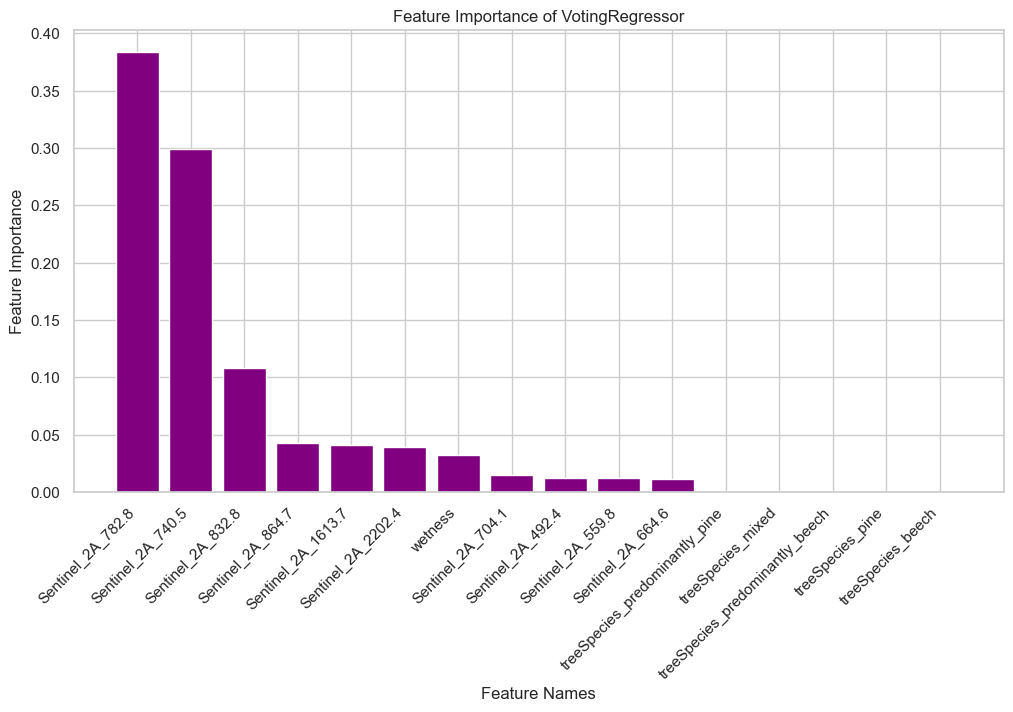

In [78]:
# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(X_train.columns[sorted_indices], feature_importances[sorted_indices], color='purple')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance")
plt.title("Feature Importance of VotingRegressor")
plt.show()

> Wavelengths from `740.5` till `2202.4` have higher feature importance than from `492.4` till `704.1`, followed by `wetness` level and the tree species do not have any importance.

#### Further Refinements that can be done.
+ Figure out the related simulated bandwidths to 740.5 till 2202.4 and then train another model.